In [ ]:
#Importing all libs
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error as mae
from tensorflow.keras import layers
from keras import Sequential
from sklearn.model_selection import RepeatedKFold, train_test_split
from keras import backend as K
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
#Mount your drive to load the input dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read the CSV
df = pd.read_csv("./drive/MyDrive/time_series_t_3.csv")
df.head()

,Unnamed: 0,vsby,alti_t-1,drct_t-1,dwpf_t-1,mslp_t-1,relh_t-1,sknt_t-1,tmpf_t-1,vsby_t-1,...,sknt_t-6,tmpf_t-6,vsby_t-6,skyc1_CLR_t-6,skyc1_FEW_t-6,skyc1_OVC_t-6,skyc1_SCT_t-6,skyc1_VV _t-6,vsby_t_1,vsby_t_2
0,27,10.000000,30.121997,19.997432,47.739828,1019.099993,96.159525,0.599923,49.6,7.000271,...,3.124807,52.0,2.781514,0.0,0.0,0.0,0.0,1.0,10.000000,9.400077
1,28,10.000000,30.117997,0.000000,47.759825,1018.749991,96.065575,0.000000,49.5,9.200046,...,2.749842,53.1,3.343980,0.0,0.0,0.0,0.0,1.0,10.000000,10.000000
2,29,8.428727,30.105997,11.998459,47.679836,1018.399996,94.211178,0.599923,48.7,8.200231,...,3.142371,53.8,5.571878,0.0,0.0,1.0,0.0,0.0,10.000000,10.000000
3,30,6.833514,30.102855,39.993071,49.856793,1018.649998,95.483764,1.713989,52.0,5.393451,...,5.666421,51.1,5.999631,0.0,0.0,1.0,0.0,0.0,8.428727,10.000000
4,31,7.500030,30.098569,51.420668,50.113851,1018.299996,95.245090,2.428279,52.9,5.214960,...,5.230652,53.1,4.768838,0.0,0.0,1.0,0.0,0.0,6.833514,8.428727


In [ ]:
#Split the CSV into X and y
ann_df = df.copy()
drop_cols = ['Unnamed: 0','vsby', 'vsby_t_1', 'vsby_t_2']

X = ann_df.drop(columns = drop_cols)
keep_cols = ['vsby', 'vsby_t_1', 'vsby_t_2']
y = ann_df[keep_cols]
# X.info()

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
def get_model_scale(n_inputs, n_outputs, loss):
  # define the model
  model = Sequential()
  model.add(layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(layers.Dense(100, activation="relu"))
  model.add(layers.Dense(50, activation="relu"))
  model.add(layers.Dense( n_outputs))
  model.compile(loss="mse", optimizer='adam', metrics = ["mse","mae"])
  return model

In [ ]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model_scale(X, y, loss):
 results = list()
 n_inputs, n_outputs = X.shape[1], y.shape[1]
 
 # define evaluation procedure
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
 if(loss == 'rmse'):
   loss = mean_squared_error()
 model = get_model_scale(n_inputs, n_outputs, loss)
 # fit model
 hist = model.fit(X_train, y_train, epochs=300)
 
 y_pred = model.predict(X_test)
 y_pred = pd.DataFrame(y_pred, columns = ['vsby', 'vsby_t_1','vsby_t_2',])
 print((X_train.shape), (X_test.shape), (y_test.shape), (y_train.shape), (y_pred.shape))
 val = []
 
 
 val.append(mean_squared_error(y_test.loc[:, "vsby_t_2":"vsby_t_2"], y_pred.loc[:, "vsby_t_2":"vsby_t_2"]))
 val.append(mean_squared_error(y_test.loc[:, "vsby_t_1":"vsby_t_1"], y_pred.loc[:, "vsby_t_1":"vsby_t_1"]))
 val.append(mean_squared_error(y_test.loc[:, "vsby":"vsby"], y_pred.loc[:, "vsby":"vsby"]))
 val.append(mae(y_test.loc[:, "vsby_t_2":"vsby_t_2"], y_pred.loc[:, "vsby_t_2":"vsby_t_2"]))
 val.append(mae(y_test.loc[:, "vsby_t_1":"vsby_t_1"], y_pred.loc[:, "vsby_t_1":"vsby_t_1"]))
 val.append(mae(y_test.loc[:, "vsby":"vsby"], y_pred.loc[:, "vsby":"vsby"]))
 if(loss == 'rmse'):
  val.append(mean_squared_error(y_test.loc[:, "vsby_t_2":"vsby_t_2"], y_pred.loc[:, "vsby_t_2":"vsby_t_2"]), squared = False)
  val.append(mean_squared_error(y_test.loc[:, "vsby_t_1":"vsby_t_1"], y_pred.loc[:, "vsby_t_1":"vsby_t_1"]), squared = False)
  val.append(mean_squared_error(y_test.loc[:, "vsby":"vsby"], y_pred.loc[:, "vsby":"vsby"]), squared = False)
 
  

 #Store results
 results.append(val)

 return results, hist.history, y_pred, y_test

In [ ]:
#Scale the input data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale = pd.DataFrame(X_scale)

In [ ]:
res, history_mae, y_pred_mae, y_actual_mae = evaluate_model_scale(X_scale, y, 'mae')
print(res)

Epoch 1/300
217/217 [==============================] - 2s 4ms/step - loss: 5.6744 - mse: 5.6744 - mae: 1.6458
Epoch 2/300
217/217 [==============================] - 1s 5ms/step - loss: 2.6520 - mse: 2.6520 - mae: 1.1335
Epoch 3/300
217/217 [==============================] - 1s 4ms/step - loss: 2.4905 - mse: 2.4905 - mae: 1.0976
Epoch 4/300
217/217 [==============================] - 1s 4ms/step - loss: 2.3661 - mse: 2.3661 - mae: 1.0624
Epoch 5/300
217/217 [==============================] - 1s 4ms/step - loss: 2.2200 - mse: 2.2200 - mae: 1.0227
Epoch 6/300
217/217 [==============================] - 1s 4ms/step - loss: 2.1621 - mse: 2.1621 - mae: 1.0151
Epoch 7/300
217/217 [==============================] - 1s 4ms/step - loss: 2.0512 - mse: 2.0512 - mae: 0.9793
Epoch 8/300
217/217 [==============================] - 1s 4ms/step - loss: 1.9724 - mse: 1.9724 - mae: 0.9637
Epoch 9/300
217/217 [==============================] - 1s 4ms/step - loss: 1.8963 - mse: 1.8963 - mae: 0.9504
Epoch 10/3

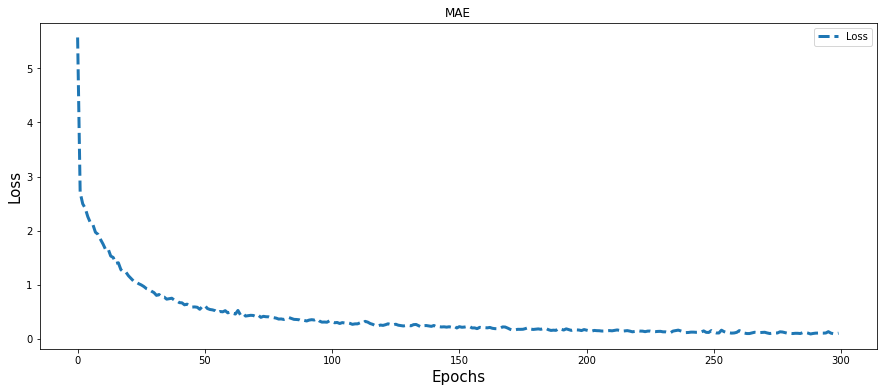

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(history_mae['loss'], lw =3, ls = '--', label = 'Loss')
# plt.plot(history_mae.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('MAE')
plt.legend()


In [ ]:
result, history_mse = evaluate_model_scale(X_scale, y, 'mse')
print(result)

Epoch 1/300
217/217 [==============================] - 1s 4ms/step - loss: 6.8318 - mse: 6.8318 - mae: 1.7476
Epoch 2/300
217/217 [==============================] - 1s 5ms/step - loss: 2.7024 - mse: 2.7024 - mae: 1.1477
Epoch 3/300
217/217 [==============================] - 1s 5ms/step - loss: 2.4536 - mse: 2.4536 - mae: 1.0746
Epoch 4/300
217/217 [==============================] - 1s 4ms/step - loss: 2.3159 - mse: 2.3159 - mae: 1.0376
Epoch 5/300
217/217 [==============================] - 1s 4ms/step - loss: 2.2487 - mse: 2.2487 - mae: 1.0265
Epoch 6/300
217/217 [==============================] - 1s 4ms/step - loss: 2.1314 - mse: 2.1314 - mae: 0.9893
Epoch 7/300
217/217 [==============================] - 1s 4ms/step - loss: 2.0354 - mse: 2.0354 - mae: 0.9727
Epoch 8/300
217/217 [==============================] - 1s 4ms/step - loss: 1.9995 - mse: 1.9995 - mae: 0.9742
Epoch 9/300
217/217 [==============================] - 1s 4ms/step - loss: 1.9220 - mse: 1.9220 - mae: 0.9515
Epoch 10/3

ValueError: ignored

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(history_mse['loss'], lw =3, ls = '--', label = 'Loss')
# plt.plot(history_mae.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('MSE')
plt.legend()

In [ ]:
#Baseline MAE
val1 = mae(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby_t_2":"vsby_t_2"])
val2 = mae(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby_t_1":"vsby_t_1"])
val3 = mae(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby":"vsby"])
print(val1, val2, val3)
#Baseline MSE
val1 = mean_squared_error(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby_t_2":"vsby_t_2"])
val2 = mean_squared_error(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby_t_1":"vsby_t_1"])
val3 = mean_squared_error(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby":"vsby"])
print(val1, val2, val3)
#Baseline RMSE
val1 = mean_squared_error(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby_t_2":"vsby_t_2"], squared = False)
val2 = mean_squared_error(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby_t_1":"vsby_t_1"], squared = False)
val3 = mean_squared_error(X.loc[:, "vsby_t-1":"vsby_t-1"],y.loc[:, "vsby":"vsby"], squared = False)
print(val1, val2, val3)


1.094279192573744 1.0540507060596767 1.01957556010979
4.518146764030951 4.30317794852125 4.116714690356805
2.125593273425316 2.0744102652371468 2.028968873678649


In [ ]:
# Baseline
# MAE => 1.094279192573744 1.0540507060596767 1.01957556010979
# MSE => 4.518146764030951 4.30317794852125 4.116714690356805
# RMSE => 2.1255932734253165 2.0744102652371468 2.028968873678649

# ANN
# MAE => [[0.9040052702730825, 0.8821307937369552, 0.8651950158480161]]
# MSE => [[2.369781763180341, 2.4011175067719734, 2.4790539957718436]]
# RMSE => [[2.61692642287105, 2.554090246855827, 2.591676969923278]]

In [ ]:
!pip install ann_visualizer

In [ ]:
from ann_visualizer.visualize import ann_viz

In [ ]:
model = get_model_scale(X_scale.shape[1], y.shape[1], 'mae')

In [ ]:
ann_viz(model, view=True, title="Deep Neural Net - Time Series prediction for [t, t+3] hours")

In [ ]:
plt.plot(y_pred_mae.iloc[:,"vsby"], y_actual_mae[:,"vsby"])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()